In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler


In [3]:
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Change working directory to Google Drive
os.chdir('/content/drive/My Drive/My Folder')


Mounted at /content/drive


In [4]:

batch_size = 32
test_size = 0.3
valid_size = 0.1

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(size=(256,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])


In [5]:
data = datasets.ImageFolder('SimLensing Dataset',transform=transform)


In [6]:

#test data
num_data = len(data)
indices_data = list(range(num_data))
np.random.shuffle(indices_data)
split_tt = int(np.floor(test_size * num_data))
train_idx, test_idx = indices_data[split_tt:], indices_data[:split_tt]

#validation data
num_train = len(train_idx)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(valid_size * num_train))
train_new_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_new_idx)
test_sampler = SubsetRandomSampler(test_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [7]:

train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
    sampler=train_sampler, num_workers=1)
valid_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(data, sampler = test_sampler, batch_size=batch_size,
    num_workers=1)
classes = [0,1]

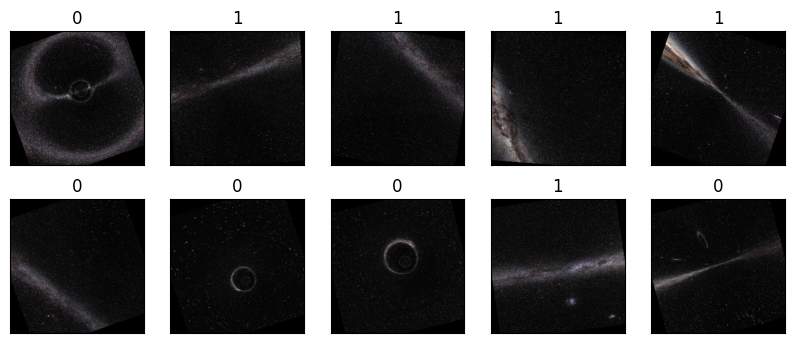

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
print(train_loader)
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10, 4))
# display 20 images
for idx in np.arange(10):
    ax = fig.add_subplot(2, int(10/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# Check if GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 32 * 32, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, 1)  # Single output neuron for binary classification
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # No sigmoid here
        return x

# Initialize model, loss function, and optimizer
model = Net().to(device)


In [12]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjusted learning rate

# Assuming train_loader and valid_loader are already defined and contain balanced datasets
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels.float())
            val_loss += loss.item()
            predicted = (outputs.squeeze() > 0.0).float()  # No sigmoid, so threshold at 0
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_val_loss = val_loss / len(valid_loader)
    val_accuracy = 100 * correct / total

    print(f"Epoch: {epoch+1} \tTraining Loss: {avg_train_loss:.6f} \tValidation Loss: {avg_val_loss:.6f} \tValidation Accuracy: {val_accuracy:.2f}%")

Epoch: 1 	Training Loss: 0.638338 	Validation Loss: 0.636981 	Validation Accuracy: 67.86%
Epoch: 2 	Training Loss: 0.611768 	Validation Loss: 0.630789 	Validation Accuracy: 67.86%
Epoch: 3 	Training Loss: 0.607961 	Validation Loss: 0.659851 	Validation Accuracy: 67.86%
Epoch: 4 	Training Loss: 0.615908 	Validation Loss: 0.631059 	Validation Accuracy: 67.86%
Epoch: 5 	Training Loss: 0.606492 	Validation Loss: 0.631694 	Validation Accuracy: 67.86%
Epoch: 6 	Training Loss: 0.609583 	Validation Loss: 0.620721 	Validation Accuracy: 67.86%
Epoch: 7 	Training Loss: 0.609735 	Validation Loss: 0.628867 	Validation Accuracy: 67.86%
Epoch: 8 	Training Loss: 0.610327 	Validation Loss: 0.590096 	Validation Accuracy: 67.86%
Epoch: 9 	Training Loss: 0.606180 	Validation Loss: 0.606766 	Validation Accuracy: 67.86%
Epoch: 10 	Training Loss: 0.577571 	Validation Loss: 0.585830 	Validation Accuracy: 67.86%
Epoch: 11 	Training Loss: 0.547168 	Validation Loss: 0.598907 	Validation Accuracy: 68.57%
Epoch: 1

In [13]:
import torch
import numpy as np

# Initialize tracking variables
test_loss = 0.0
class_correct = [0 for _ in range(2)]
class_total = [0 for _ in range(2)]

model.eval()  # Set model to evaluation mode

# Iterate over test data
for data, target in test_loader:
    # Move tensors to GPU if CUDA is available
    data, target = data.to(device), target.to(device)

    # Forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)

    # Calculate the batch loss
    loss = criterion(output.squeeze(), target.float())
    test_loss += loss.item() * data.size(0)

    # Convert output probabilities to predicted class (binary classification)
    pred = (torch.sigmoid(output.squeeze()) > 0.5).float()  # Apply sigmoid and threshold

    # Compare predictions to true labels
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = correct_tensor.cpu().numpy() if device.type == 'cuda' else correct_tensor.numpy()

    # Calculate test accuracy for each class
    for i in range(len(target)):
        label = target.data[i].item()
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# Average test loss
test_loss /= len(test_loader.dataset)
print('Test Loss: {:.6f}'.format(test_loss))

# Print accuracy for each class
for i in range(2):
    if class_total[i] > 0:
        print(f'Test Accuracy of class {i}: {100 * class_correct[i] / class_total[i]:.2f}% ({int(class_correct[i])}/{int(class_total[i])})')
    else:
        print(f'Test Accuracy of class {i}: N/A (no training examples)')

# Print overall test accuracy
print(f'\nTest Accuracy (Overall): {100. * np.sum(class_correct) / np.sum(class_total):.2f}% ({int(np.sum(class_correct))}/{int(np.sum(class_total))})')

Test Loss: 0.094218
Test Accuracy of class 0: 93.68% (267/285)
Test Accuracy of class 1: 84.13% (265/315)

Test Accuracy (Overall): 88.67% (532/600)


In [14]:
torch.save(model.state_dict(), 'model_params.pth')